# Computational Social Science Project #3 

**Enter your Name:**Juana Montoya-Murillo
*Semester:* Fall 2023

## 1. Introduction

### Load data 

In [1]:
!pip install xgboost
!pip install pymc
!pip install pymc_bart

In [2]:
#
# load libraries
# -----------
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, make_scorer, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import DataConversionWarning
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
 

import xgboost as xgb
from xgboost import XGBClassifier


import arviz as az                 # ArviZ is a Python package for exploratory analysis of Bayesian models
import pymc as pm                  # PyMC (formerly PyMC3) is a Python package for Bayesian statistical modeling
import pymc_bart as pmb            # PyMC-BART extends PyMC 

# There are a few warnings that will appear that will not affect your analysis. Run this code to ignore. 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Make sure to import other libraries that will be necessary for training models!

# Set seed
np.random.seed(10)


# settings
%matplotlib inline
sns.set_style("darkgrid")


/srv/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/srv/conda/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
#
# read in "Inspections Data 2011-2013" csv data
# -----------
chicago_inspections_2011_to_2013 = pd.read_csv("data/Chicago Inspections 2011-2013.csv", 
                                              low_memory=False)


In [4]:
# look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [5]:
# list column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [6]:
# drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns = ['AKA_Name', 
                                                 'License',
                                                 'Address',
                                                 'City',
                                                 'State',
                                                 'Zip',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Location',
                                                 'ID',
                                                 'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                 'ACCOUNT_NUMBER',
                                                 'LEGAL_NAME',
                                                 'DOING_BUSINESS_AS_NAME',
                                                 'ADDRESS',
                                                 'CITY',
                                                 'STATE',
                                                 'ZIP_CODE',
                                                 'WARD',
                                                 'PRECINCT',
                                                 'LICENSE_CODE',
                                                 'BUSINESS_ACTIVITY_ID',
                                                 'BUSINESS_ACTIVITY',
                                                 'LICENSE_NUMBER',
                                                 'LATITUDE',
                                                 'LONGITUDE',
                                                 'pass_flag',
                                                 'fail_flag'],
                                     inplace = True)

# set index
chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [7]:
# convert the inspection date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'])  

### Visualization

Let's visualize what inspections look like over time.

<Axes: title={'center': 'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

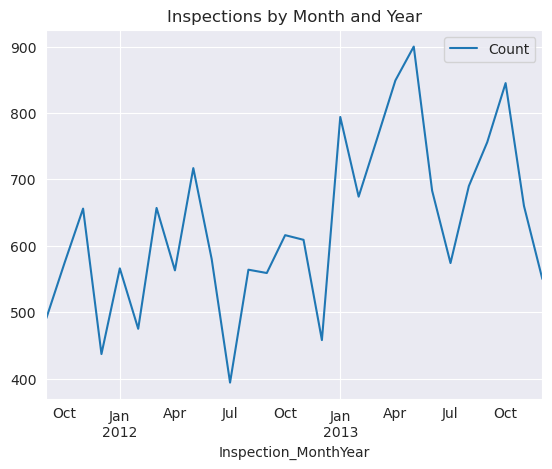

In [8]:
# visualize inspections over time
# -----------
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year") 

Let's visualize what the distribution of results looks like.

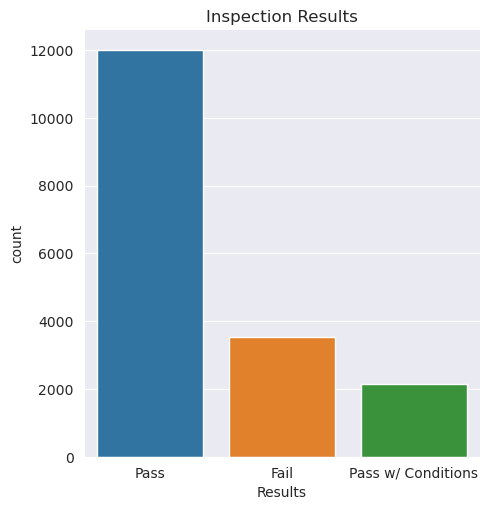

In [9]:
# view inspection results
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate results by facility type?

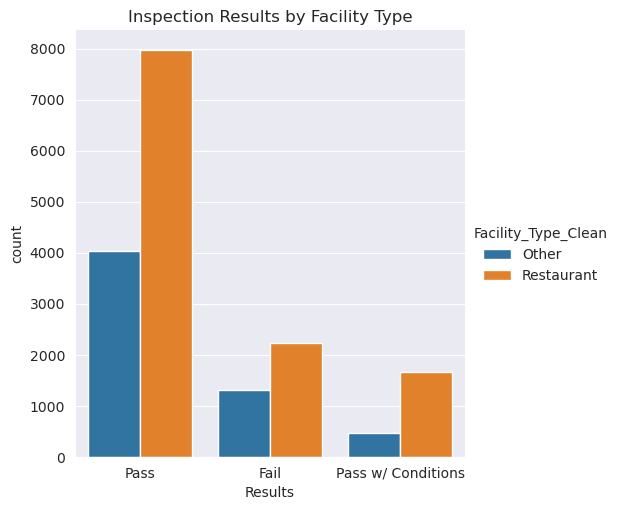

In [10]:
# view inspection results by facility type (restaurant or not)
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
            x = "Results",
            kind = "count",
            hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show();

## 2. Data Preprocessing and Cleaning

In [11]:
# drop datetime info
# -----------
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                                                                   'minDate',
                                                                                   'maxDate',
                                                                                   'Inspection_MonthYear'],
                                                                                  axis = 1)

In [12]:
# process target 
# -----------
y = chicago_inspections_2011_to_2013['Results']

# decide if you want to binarize the outcome variable 
# -----------
# comment out the following lines of code if you don't want to binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)

# recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)



X = chicago_inspections_2011_to_2013
chicago_inspections_2011_to_2013['Results'].replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
chicago_inspections_2011_to_2013['Results'] = lb_style.fit_transform(chicago_inspections_2011_to_2013['Results'])

# recode 0s and 1s so 1s are "Fail"
chicago_inspections_2011_to_2013['Results'] = np.where(chicago_inspections_2011_to_2013['Results'] == 1, 0 ,1)

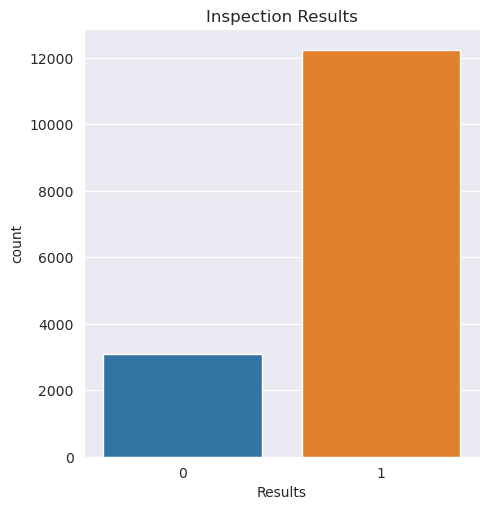

In [13]:
sns.catplot(data = X,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

In [14]:
# process features
# -----------

# create feature dataset
X = chicago_inspections_2011_to_2013.drop(columns = ['Results',
                                                    'Facility_Type', 
                                                     'LICENSE_DESCRIPTION', 
                                                     'WARD_PRECINCT'])

# get dummies
X = pd.get_dummies(X)

In [15]:
# view feature datset
X.head()

,,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,POLICE_DISTRICT,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound,Risk_Risk 1 (High),Risk_Risk 2 (Medium),Risk_Risk 3 (Low),Inspection_Type_Canvass,Facility_Type_Clean_Other,Facility_Type_Clean_Restaurant,APPLICATION_TYPE_C_EXPA,APPLICATION_TYPE_C_LOC,APPLICATION_TYPE_ISSUE,APPLICATION_TYPE_RENEW
Inspection_ID,DBA_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269961,SEVEN STAR,0,0,2,0,0,0,0,2.0,1,19.0,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0,False,False,True,True,True,False,False,False,False,True
507211,PANERA BREAD,0,0,3,0,0,0,0,2.0,1,24.0,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0,True,False,False,True,False,True,False,False,False,True
507212,LITTLE QUIAPO RESTAURANT,0,2,6,0,0,0,0,2.0,1,17.0,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0,True,False,False,True,False,True,False,False,False,True
507216,SERGIO'S TAQUERIA PIZZA INC.,0,0,6,0,0,0,0,2.0,1,17.0,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0,True,False,False,True,False,True,False,False,False,True
507219,TARGET STORE # T-2079,0,2,6,0,0,0,0,2.0,1,24.0,5.290411,0,0,1,0,0,1,0,0,0,0,0,0,0.009987,52.730000,16.266667,0.690000,9.530785,3.401567,2.126788,0,False,True,False,True,False,True,False,False,False,True


## 3. Fit Models

### Data Splitting

Now choose 3 different machine learning techniques and apply them below. Choose from one of the algorithms we have used in lab (e.g., logistic regression, random forests, `AdaBoost()`, `xgboost()`, `VotingClassifer()`, or `BART`). 

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem. Also, be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using either train/validation splits or cross-validation)

**For the task of predicting the outcomes of food safety inspections, I selected three machine learning models: Logistic Regression, Random Forest, and XGBoost. Each of these models brings a unique approach to the problem, and their varied assumptions and mechanics offer a comprehensive view when combined.**

### Model 1- Logistic

**Logic and Assumptions:** Logistic regression is used for binary classification problems. It assumes a linear relationship between the independent variables and the log-odds of the dependent variable.

**Pros/Cons:** It's simple, interpretable, and efficient for small datasets but may underperform with non-linear relationships.

**Plausibility for this Problem:** Good for establishing a baseline; might work well if the relationship is approximately linear.Given the binary nature of your target variable (pass or fail), logistic regression is aptly suited. If the relationship between features like business information, previous inspection results, and neighborhood information and the inspection outcome is somewhat linear, logistic regression can provide a good baseline model. 

In [16]:
log_reg_params =[{'penalty': ['l2'], 'solver': ['lbfgs'],'C': np.arange(.1, 1, .1)},
                {'penalty': ['l1'], 'solver': ['liblinear'], 'C': np.arange(.1, 1, .1)}
                 ]
            # 'fit_intercept': [True, False],
            # 'solver': ['liblinear', 'saga']}

# Logistic Regression with cross-validation and hyperparameter tuning
log_reg_cv = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, scoring='accuracy')
log_reg_cv.fit(X, y)
print("Logistic Regression best params:", log_reg_cv.best_params_)
print("Logistic Regression best score:", log_reg_cv.best_score_)

Logistic Regression best params: {'C': 0.4, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression best score: 0.9226044487491398


###  Model 2- Xgboost

**Logic and Assumptions:** XGBoost is a gradient boosting framework that uses decision trees as base learners. It's designed for speed and performance.

**Pros/Cons:** Highly efficient, works well with a variety of data types, but can be prone to overfitting and less interpretable.

**Plausibility for this Problem:** Effective if there are complex, non-linear relationships in the data. Given that the dataset comprises various factors from business and neighborhood information to past inspection results, XGBoost's ability to capture complex patterns could prove invaluable. 

In [17]:
# initialize an XGBoost classifier
xgb_params = {'max_depth': [3, 5],
    #'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [200, 400]}
    #'min_child_weight': [1, 2, 3],
    #'subsample': [0.6, 0.8, 1.0]}

# XGBoost with cross-validation and hyperparameter tuning
xgb_cv = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_cv.fit(X, y)
print("XGBoost best params:", xgb_cv.best_params_)
print("XGBoost best score:", xgb_cv.best_score_)



XGBoost best params: {'max_depth': 5, 'n_estimators': 200}
XGBoost best score: 0.917445041031438


### Model 3- Random Forest

**Logic and Assumptions:** Random Forest is an ensemble of decision trees. It assumes that a collection of weak learners can combine to form a strong learner.

**Pros/Cons:** Handles non-linear data well, less prone to overfitting, but can be computationally intensive and less interpretable.

**Plausibility for this Problem:** Useful if the decision boundary is complex and non-linear.Since the dataset includes a mix of business, neighborhood, and inspection history data, the Random Forest algorithm can effectively capture the interactions between these diverse features. Its ensemble nature, where multiple decision trees vote on the outcome, could provide a more nuanced understanding of what factors contribute to a business passing or failing an inspection.

In [18]:
rf_params = {'n_estimators': [200, 300],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5]}

# Randomforest with cross-validation and hyperparameter tuning
rf_cv = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_cv.fit(X, y)
print("RandomForest best params:", rf_cv.best_params_)
print("RandomForest best score:", rf_cv.best_score_)

RandomForest best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest best score: 0.9254785792713991


### Validation Metrics

Be sure to explain which of these metrics you would want to prioritize when conducting predictive auditing in this context and why.

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

Choosing metrics:
1. Accuracy might be chosen if the overall correctness of predictions is the main concern
2. Recall might be more important if missing a 'Fail' is more critical
3. Precision is crucial if we want to minimize false alarms ('Fail' predictions that are actually 'Pass')
4. F1 Score is a balance between Precision and Recall


In [19]:
# Evaluate models using cross-validated metrics
for name, model in {'Logistic Regression': log_reg_cv.best_estimator_, 'XGBoost': xgb_cv.best_estimator_, 'RandomForest': rf_cv.best_estimator_}.items():
    print(f"{name} Model Cross-Validated Metrics:")
    print("Accuracy:", np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy')))
    print("Recall:", np.mean(cross_val_score(model, X, y, cv=5, scoring='recall')))
    print("Precision:", np.mean(cross_val_score(model, X, y, cv=5, scoring='precision')))
    print("F1 Score:", np.mean(cross_val_score(model, X, y, cv=5, scoring='f1')))

Logistic Regression Model Cross-Validated Metrics:
Accuracy: 0.9225391532871745
Recall: 0.8532894840364431
Precision: 0.7840861626882927
F1 Score: 0.8162679332742929
XGBoost Model Cross-Validated Metrics:
Accuracy: 0.917445041031438
Recall: 0.8205546201738236
Precision: 0.7817340752303774
F1 Score: 0.8002376461515086
RandomForest Model Cross-Validated Metrics:
Accuracy: 0.9239111043441527
Recall: 0.9008942948707862
Precision: 0.7673963782051605
F1 Score: 0.8257527019490383


In our project to make food safety checks better, I tried three different computer models - logistic regression, XGBoost, and random forest - to find out which one could best tell us which restaurants might fail a health inspection. Here's what I found out after running some detailed tests:

- The logistic regression model was really accurate, scoring 0.92 in accuracy. It was great at identifying most places that could fail an inspection (recall of 0.85) and was fairly good at not flagging places that were actually okay (precision of 0.78). Overall, it balanced these two aspects well, getting an F1 score of 0.82.

- The XGBoost model was also pretty accurate with a score of 0.92, a bit good at finding places that might fail (recall of 0.82), and similar to logistic regression in precision (0.78). Its overall balance gave it an F1 score of 0.80.

- The random forest model turned out to be the most accurate, with a score of 0.92. It was the best at catching places that might not pass the inspection (recall of 0.90), but it wasn't as precise as the other models (precision of 0.77), leading to an F1 score of 0.83.

In simple terms, all these models did a great job, but each had its strengths. Logistic regression was a good all-rounder, XGBoost was a close second, and random forest was the best at making sure we don't miss any restaurants that could be a health risk. This helps us focus on inspecting the right places, making sure we keep everyone safe without wasting resources.

## 4. Policy Simulation

### Interpretable Machine Learning

Use tools like coefficient plots or feature importance plots to investigate your models. Which features contribute to your predictions? Are there any additional features you wish you could incorporate that you don't have available in this analysis?

**Hint**: Use tools like feature importance plots and coefficient plots.

###  Coefficient Plot for Logistic Regression

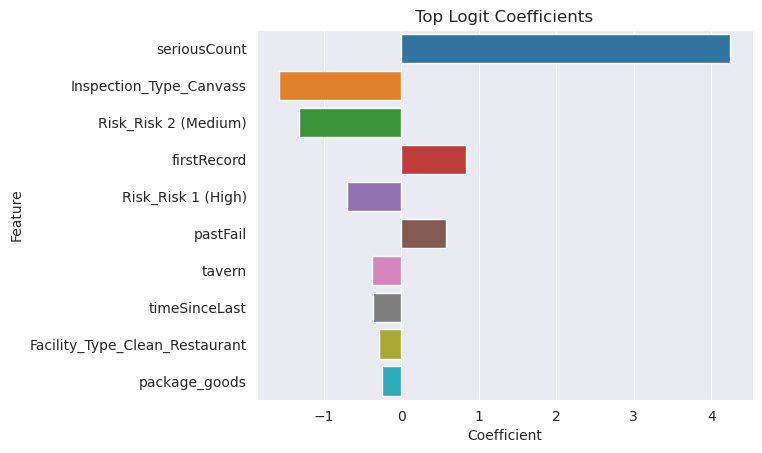

In [20]:
best_log_reg = log_reg_cv.best_estimator_
coefficients = best_log_reg.coef_[0]

# extract the coefficents and create a dataframe for plotting 
logit_data = pd.concat([pd.DataFrame(X.columns),
                        pd.DataFrame(np.transpose(best_log_reg.coef_))],
                       axis = 1)

logit_data.columns = ['Feature', 'Coefficient']
logit_data['abs_coef'] = abs(logit_data['Coefficient'])

# plot 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=logit_data.nlargest(10, 'abs_coef')).set_title("Top Logit Coefficients")
plt.show()

### Feature Importance Plot for XGBoost

XGBoost


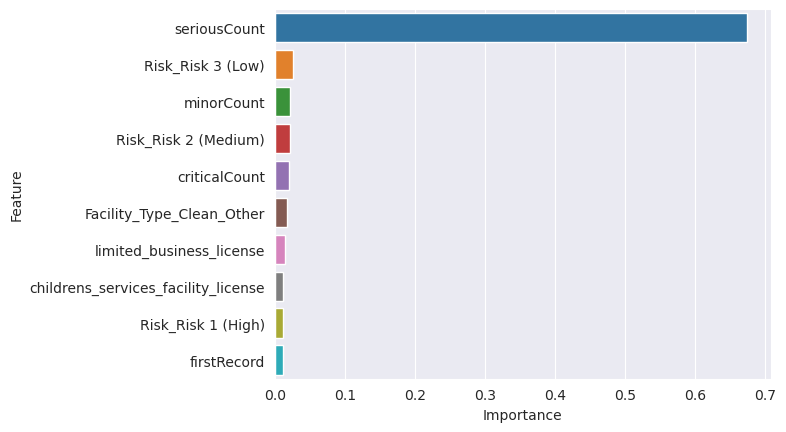

In [21]:
best_xgb = xgb_cv.best_estimator_
xgb_importances = best_xgb.feature_importances_

# Creating a DataFrame for visualization
print("XGBoost")
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(best_xgb.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]

# plot 
sns.barplot(x = "Importance", 
            y = "Feature", 
            
            data = feat_importances.nlargest(10, 'Importance')) # identify the 10 most important features
plt.show()

### Feature Importance Plot for Random Forest

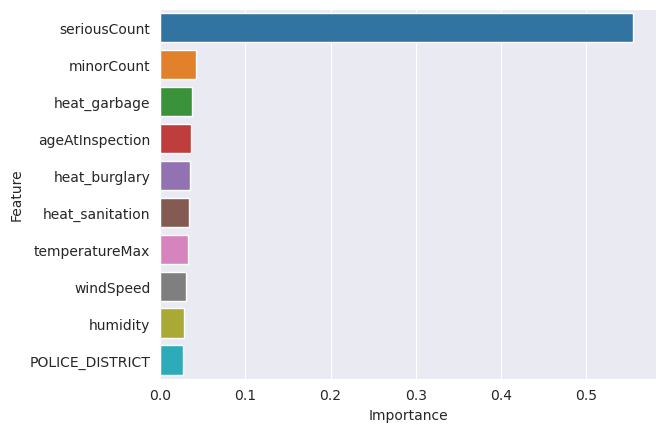

In [22]:
best_rf = rf_cv.best_estimator_
rf_importances = best_rf.feature_importances_

# random forest
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(best_rf.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]

# plot 
sns.barplot(x = "Importance", 
            y = "Feature", 
            data = feat_importances.nlargest(10, 'Importance')) # identify the 10 most important features
plt.show()

**Which features contribute to your predictions? Are there any additional features you wish you could incorporate that you don't have available in this analysis?**


In analyzing food safety inspection predictions, our models highlighted several key features. The 'seriousCount' is a major predictor across all models, indicating that the number of serious past violations is crucial in forecasting inspection outcomes. Risk levels and inspection types also play significant roles, especially in logistic regression.

While these features are informative, incorporating detailed data like specific violation types, customer volume, and staff training could further improve predictions. Adding real-time inputs, such as customer reviews, might also give us a better picture of which establishments are at risk of failing health inspections.


### Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random

**To refine our approach to predicting food inspection outcomes, I've opted to utilize the Random Forest model, renowned for its robustness and accuracy in handling diverse datasets.**

In [23]:
#
# 1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities.
# -----------
best_rf = rf_cv.best_estimator_
predicted_outcomes = best_rf.predict(X)  # Predicted outcomes
predicted_probabilities = best_rf.predict_proba(X)[:, 1] #Predicted probabilities

In [24]:
#
# 2. Order your audits by their probability of detecting a "Fail" score
# -----------
# get sorted indices (from largest to smallest probability)
ordered_audits = np.argsort(predicted_probabilities)[::-1]

# reorder the observations by this sorting of indices 
ordered_audits_X = X.iloc[ordered_audits]
ordered_audits_y = y[ordered_audits]

# choose audits 
audits_X = ordered_audits_X.iloc[0:1000]
audits_y = ordered_audits_y[0:1000]


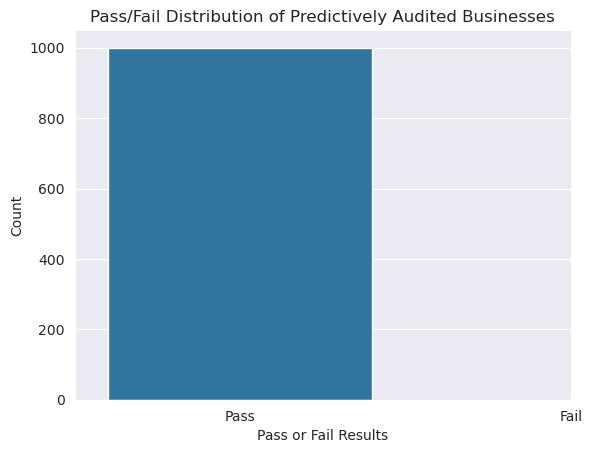

In [25]:
#
# 3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
# -----------
# Create a new DataFrame with labels
df = pd.DataFrame({'Inspection_Result': audits_y.ravel()})
df['Label'] = df['Inspection_Result'].map({0: 'Pass', 1: 'Fail'})

# plot
sns.countplot(x='Inspection_Result', data=df)

# setting labels and title for clarity
plt.xticks(ticks=[0, 1], labels=['Pass', 'Fail'])
plt.xlabel('Pass or Fail Results')
plt.ylabel('Count')
plt.title('Pass/Fail Distribution of Predictively Audited Businesses')
plt.show()

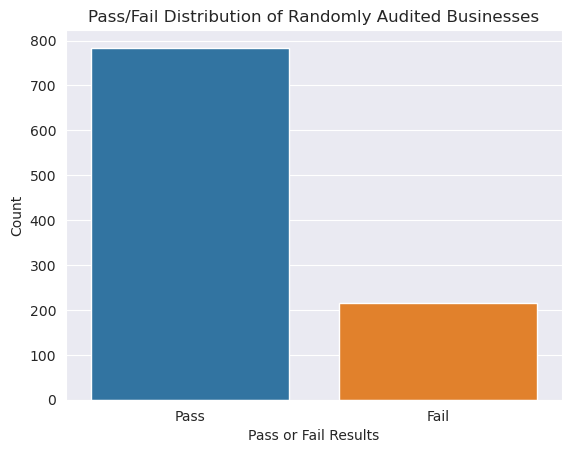

In [26]:
#
# 4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random
# -----------
random_audit_y = np.random.choice(y.flatten(), 1000, replace=False)

# Create a new DataFrame with labels
df = pd.DataFrame({'Inspection_Result': random_audit_y.ravel()})
df['Label'] = df['Inspection_Result'].map({0: 'Pass', 1: 'Fail'})

# plot
sns.countplot(x='Inspection_Result', data=df)

# setting labels and title for clarity
plt.xticks(ticks=[0, 1], labels=['Pass', 'Fail'])
plt.xlabel('Pass or Fail Results')
plt.ylabel('Count')
plt.title('Pass/Fail Distribution of Randomly Audited Businesses')
plt.show()


With the resources to conduct only 1,000 food safety inspections, the City of Chicago could greatly benefit from a targeted approach. Utilizing the Random Forest model, we prioritized inspections by identifying the 1,000 establishments with the highest risk of violations. The first plot demonstrates the efficacy of this approach, with a significant number of establishments predicted to fail, thus potentially preventing health hazards.

In contrast, a simulation of 1,000 random audits, represented in the second plot, shows a more balanced distribution of pass and fail outcomes, reflecting less efficiency in detecting violations. This comparison clearly illustrates the advantage of predictive over random auditing. By focusing on the riskiest establishments, the algorithm significantly improves the likelihood of finding potential violations, optimizing resource allocation and enhancing public health safety measures.

### Predict on 2014 inspection data

Use your favorite model to make predictions based on the features using the "Chicago Inspection 2014_updated.csv" file. Treat this as you would a test dataset. This means you will have to format the features (including removing some features and getting dummies) and the label (binarize and recode) in the same way you did the training data. (Remember the "Results" column is your label). You will then compare your predictions with the actual.

In [27]:
# read in  "Inspections Data 2014_updated" csv data
# -----------
chicago_inspections_2014 = pd.read_csv("data/Chicago Inspections 2014_updated.csv",  # be sure to use the "updated" data here
                                      low_memory=False)

In [28]:
chicago_inspections_2014.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound,Results
0,920444,2014-01-15,GALLISTEL LANGUAGE ACADEMY,GALLISTEL LANGUAGE ACADEMY,2046708,School,Risk 1 (High),10200 S AVENUE J,CHICAGO,IL,60617.0,Canvass,41.709957,-87.534223,"(41.70995714781606, -87.5342225149751)",Other,0,1,5,0,0,0,2,0.964384,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,41.67,13.533333,0.726667,2.149376,7.705332,9.535848,0,Fail
1,920445,2014-02-03,SUBWAY,SUBWAY,2183563,Restaurant,Risk 1 (High),4025 E 106TH ST,CHICAGO,IL,60617.0,Canvass,41.702577,-87.525872,"(41.70257660937248, -87.52587169711877)",Restaurant,2,0,0,0,0,0,0,0.794521,0,2183563-20120829,2183563.0,375027.0,AMI SUB INC.,SUBWAY,4025 E 106TH ST 1,CHICAGO,IL,60617.0,10.0,38.0,10-38,4.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,2183563.0,ISSUE,2012-08-29,2014-09-15,AAI,41.702577,-87.525872,2012-08-29,2018-09-15,1.432877,0,0,0,0,0,0,0,0,0,0,0,0,0.002300,28.16,6.020000,0.746667,12.034833,7.194320,1.219222,1,Pass w/ Conditions
2,920446,2014-02-03,SHARKS FISH & CHICKEN,SHARKS FISH & CHICKEN,1477112,Restaurant,Risk 2 (Medium),2027 E 95TH ST,CHICAGO,IL,60617.0,Canvass,41.722372,-87.574275,"(41.72237211196818, -87.57427469548966)",Restaurant,0,0,6,0,0,0,2,0.660274,0,1477112-20120716,2155150.0,273266.0,"A & K SHARKS, INC.",SHARKS FISH & CHICKEN,2027 E 95TH ST,CHICAGO,IL,60617.0,7.0,49.0,7-49,4.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1477112.0,RENEW,2012-07-16,2014-07-15,AAI,41.722372,-87.574275,2004-03-02,2018-07-15,9.931507,0,0,0,0,0,0,0,0,0,0,0,0,0.002300,28.16,6.020000,0.746667,26.292725,27.837325,12.401466,0,Pass
3,920448,2014-03-07,P K PETRO INC.,MARATHON,1331469,Grocery Store,Risk 3 (Low),7001 S STONY ISLAND AVE,CHICAGO,IL,60649.0,Canvass,41.767798,-87.585820,"(41.76779762303839, -87.58581991823232)",Other,0,1,7,0,0,0,0,2.000000,1,1331469-20121216,2194284.0,257899.0,P K PETRO INC.,Stony Shell,7001 S STONY ISLAND AVE,CHICAGO,IL,60649.0,5.0,21.0,5-21,3.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1331469.0,RENEW,2012-12-16,2014-12-15,AAI,41.767798,-87.585820,2003-03-05,2018-12-15,11.013699,0,1,0,0,0,0,0,0,0,1,0,0,0.000433,25.30,7.653333,0.636667,49.468944,11.282325,66.467028,0,Fail
4,920449,2014-03-07,"Z T DOLLAR EXCHANGE,INC",DOLLAR STORE,2189299,Grocery Store,Risk 3 (Low),2429 E 72ND ST,CHICAGO,IL,60649.0,Canvass,41.764339,-87.565371,"(41.764339216775696, -87.5653706801239)",Other,1,2,5,0,0,0,0,2.000000,1,2189299-20121009,2189299.0,249904.0,"ZT DOLLAR EXCHANGE, INC.","Z T DOLLAR EXCHANGE, INC.",2429 E 72ND ST,CHICAGO,IL,60649.0,7.0,40.0,7-40,3.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,2189299.0,ISSUE,2012-10-09,2014-12-15,AAI,41.764339,-87.565371,2012-10-09,2018-12-15,1.408219,0,1,0,0,0,1,0,0,0,0,0,0,0.000433,25.30,7.653333,0.636667,69.939833,26.695701,76.827119,1,Fail


In [29]:
# data processing
# -----------

# process features
chicago_inspections_2014.drop(columns = ['AKA_Name', 
                                                 'License',
                                                 'Address',
                                                 'City',
                                                 'State',
                                                 'Zip',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Location',
                                                 'ID',
                                                 'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                 'ACCOUNT_NUMBER',
                                                 'LEGAL_NAME',
                                                 'DOING_BUSINESS_AS_NAME',
                                                 'ADDRESS',
                                                 'CITY',
                                                 'STATE',
                                                 'ZIP_CODE',
                                                 'WARD',
                                                 'PRECINCT',
                                                 'LICENSE_CODE',
                                                 'BUSINESS_ACTIVITY_ID',
                                                 'BUSINESS_ACTIVITY',
                                                 'LICENSE_NUMBER',
                                                 'LATITUDE',
                                                 'LONGITUDE'],
                                     inplace = True)

chicago_inspections_2014.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

# Convert the Inspection Date to a datetime format
chicago_inspections_2014['Inspection_Date'] = pd.to_datetime(chicago_inspections_2014['Inspection_Date'], infer_datetime_format=True)  

# drop datetime info
# -----------
chicago_inspections_2014 = chicago_inspections_2014.dropna().drop(['Inspection_Date',
                                                                    'minDate',
                                                                    'maxDate'],
                                                                    axis = 1)

# process features
X_test2014 = chicago_inspections_2014.drop(columns = ['Results', 
                                                     'Facility_Type', 
                                                     'LICENSE_DESCRIPTION', 
                                                     'WARD_PRECINCT'])


# get dummies
X_test2014 = pd.get_dummies(X_test2014)

# process target 
y_test2014 = chicago_inspections_2014['Results']

# binarize the outcome variable 
# -----------
y_test2014 = y_test2014.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y_test2014 = lb_style.fit_transform(y_test2014)

# recode 0s and 1s so 1s are "Fail"
y_test2014 = np.where(y_test2014 == 1, 0 ,1)


In [30]:
# predict and compare 
# -----------
test_predictions = best_rf.predict(X_test2014)


In [31]:
# evaluate
# -----------
# Calculate metrics

accuracy = accuracy_score(y_test2014, test_predictions)
recall = recall_score(y_test2014, test_predictions)

print("Accuracy:", accuracy)
print("Recall:", recall)

Accuracy: 0.9062738125476251
Recall: 0.8622448979591837


After teaching the model with the latest Chicago food safety data, it did a really good job. It got about 91% of its predictions right and was especially good at spotting the places that might have problems, with an accuracy of about 86%. This high "spotting" score, or recall, is super important. It means our model can catch most of the risky restaurants, helping the city inspectors know which places to check first. This is great because it means they can use their time and money to make sure our food is safe, instead of visiting restaurants that are already doing well.

## 5. Discussion Questions

1. Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?


**ANSWER:** When we use machine learning in areas like social sciences and public policy, accuracy alone isn't enough because it doesn't tell the whole story. Let's say we have a model that predicts whether a restaurant will pass a health check. If most restaurants usually pass, a model could just predict "pass" for all and still be mostly right, but it would miss the few that don't pass, which could be really risky for public health. That's why we also look at things like recall (how good the model is at catching all the risky places) and precision (making sure the places the model thinks might fail are actually at risk).

2. Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decisionmaking and real world behavior?

**ANSWER:** If restaurants start changing things just to avoid failing inspections because they know what the model is looking at, that's a problem. It's like changing your answers on a test because you know what the teacher is grading on, not because you actually know the material. To stop this, policymakers could mix things up every few years, retraining the models with new data so that restaurants can't game the system. They should also keep talking to the food inspectors who know the tricks restaurants might try to hide problems. This way, we can update our data and keep our models sharp, making sure they're catching real issues and helping restaurants actually be safer, not just look safer.